In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Import Data

In [3]:
# import our cleaned data from EDA
data = pd.read_csv("data/data_clean.csv", index_col = False)

In [4]:
# define our features that are categories
# these features will be encoded later
categories = ["property_type","product_depth"]
data[categories] = data[categories].apply(lambda x: x.astype("category"))

In [5]:
# check a sample of the data
data.sample(10, random_state = 123)

,building_size,land_size,price,bedroom_count,bathroom_count,parking_count,property_type,product_depth
656,198.0,178.0,450000.0,3.0,2.0,2.0,Apartment,premiere
275,210.0,818.0,420000.0,3.0,1.0,4.0,House,premiere
327,210.0,804.0,490000.0,3.0,2.0,2.0,House,premiere
285,135.0,178.0,380000.0,3.0,2.0,2.0,Apartment,standard
280,210.0,813.0,435000.0,3.0,1.0,2.0,House,premiere
754,210.0,804.0,500000.0,4.0,2.0,2.0,House,feature
202,210.0,343.0,555000.0,4.0,2.0,2.0,House,premiere
145,172.0,178.0,559000.0,2.0,2.0,1.0,Apartment,standard
774,149.0,804.0,515000.0,4.0,2.0,2.0,House,premiere
700,155.0,487.0,555000.0,3.0,2.0,2.0,House,premiere


In [6]:
# set our predictors and target variables
X = data.drop("price", axis = 1)
y = data["price"]

# Data Pipeline(s)

In [7]:
# split our data into training and testing data (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [8]:
X_train.head()

,building_size,land_size,bedroom_count,bathroom_count,parking_count,property_type,product_depth
200,210.0,804.0,5.0,2.0,6.0,House,premiere
763,86.0,153.0,1.0,1.0,1.0,Unit,premiere
752,210.0,369.0,6.0,3.0,3.0,House,feature
779,107.0,158.0,2.0,2.0,2.0,Unit,premiere
246,107.0,261.0,3.0,2.0,3.0,Unit,premiere


In [9]:
# set up scaling step for numeric columns
nums = X.drop(categories, axis = 1).columns
num_trans = Pipeline(
    steps = [("scaler", StandardScaler())]
)

# set up one hot encoder for categorical variables
cat_trans = OneHotEncoder(handle_unknown = "ignore")

In [10]:
# combine scaling and encoding into a single column transformer
processor = ColumnTransformer(
    transformers = [
        ("num", num_trans, nums),
        ("cat", cat_trans, categories)
    ]
)

# Models

In [11]:
# build a pipeline using the preprocessor ColumnTransformer
# and the model specified
def pipeMaker(model):
    # two steps:
    # - a preprocessing step to encode and scale the data
    # - a model step to fit the model on the transformed data
    pipe = Pipeline(
        steps = [("preprocessor", processor), ("model", model)]
    ) 
    return pipe

In [12]:
# prints out model metrics
def printMetrics(string, y_train_pred, y_train, y_test_pred, y_test):
    # model label
    print(string + " Performance")
    
    # training regression metrics
    print("\nTraining")
    print("RMSE: "+ str(mean_squared_error(y_train, y_train_pred, squared = False)))
    print("MAE: "+ str(mean_absolute_error(y_train, y_train_pred)))
    
    # testing regression metrics
    print("\nTest")
    print("RMSE: "+ str(mean_squared_error(y_test, y_test_pred, squared = False)))
    print("MAE: "+ str(mean_absolute_error(y_test, y_test_pred)))

In [13]:
# get model performance, comparing training and testing metrics
def getModelPerf(string, pipe, X_train, y_train, X_test, y_test):
    # get predicted train/test values
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # prints out model performance metrics
    printMetrics(string, y_train_pred, y_train, y_test_pred, y_test)   

## Baseline Model (median)

In [14]:
# make the predicted values the median housing price
pred_train = [np.median(data["price"])] * len(y_train)
pred_test = [np.median(data["price"])] * len(y_test)

In [15]:
# baseline model performance
printMetrics("Baseline (median) Model", pred_train, y_train, pred_test, y_test)   

Baseline (median) Model Performance

Training
RMSE: 140709.85860185194
MAE: 112789.31962025317

Test
RMSE: 124670.31404384715
MAE: 98649.28909952607


## Decision Tree

In [16]:
# decision tree pipeline
regress_dt = DecisionTreeRegressor(random_state = 123, ccp_alpha = 0.1)
dt = pipeMaker(regress_dt)

# determine best parameters using a parameter grid
param_grid = {
    'model__max_depth': [1, 3, 5, 10],
    'model__min_samples_split': [5, 10, 20],
    'model__min_samples_leaf':[5, 10, 15],
    'model__max_features':["auto", "sqrt", "log2"] 
}

# use gridsearchCV to determine which model params lead to the best model
# based on RMSE
dt_test = GridSearchCV(dt, param_grid, cv=10, scoring = "neg_mean_squared_error")
dt_test.fit(X_train, y_train)
dt_test.best_params_

{'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 5}

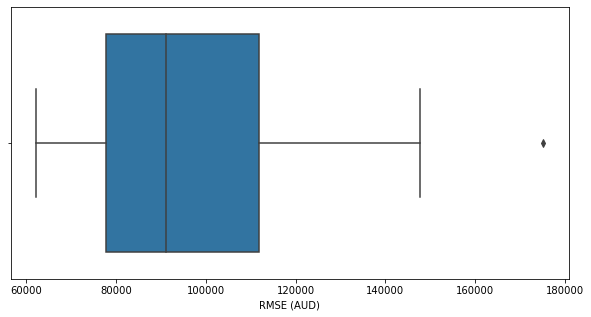

In [17]:
scores = cross_val_score(dt_test.best_estimator_, X_test, y_test, scoring = "neg_mean_squared_error", cv = 25)
RMSEs = (-1 * scores)**0.5

plt.figure(figsize = (10, 5))
sb.boxplot(x = RMSEs)
plt.xlabel("RMSE (AUD)")
plt.show()

In [18]:
# looking at our best model according to GridSearchCV:
# not much overfitting- values are as expected for RMSE
getModelPerf("Decision Tree Model", dt_test, X_train, y_train, X_test, y_test)

Decision Tree Model Performance

Training
RMSE: 88948.44202486823
MAE: 67639.61169522975

Test
RMSE: 94997.46552529749
MAE: 71849.56353578318


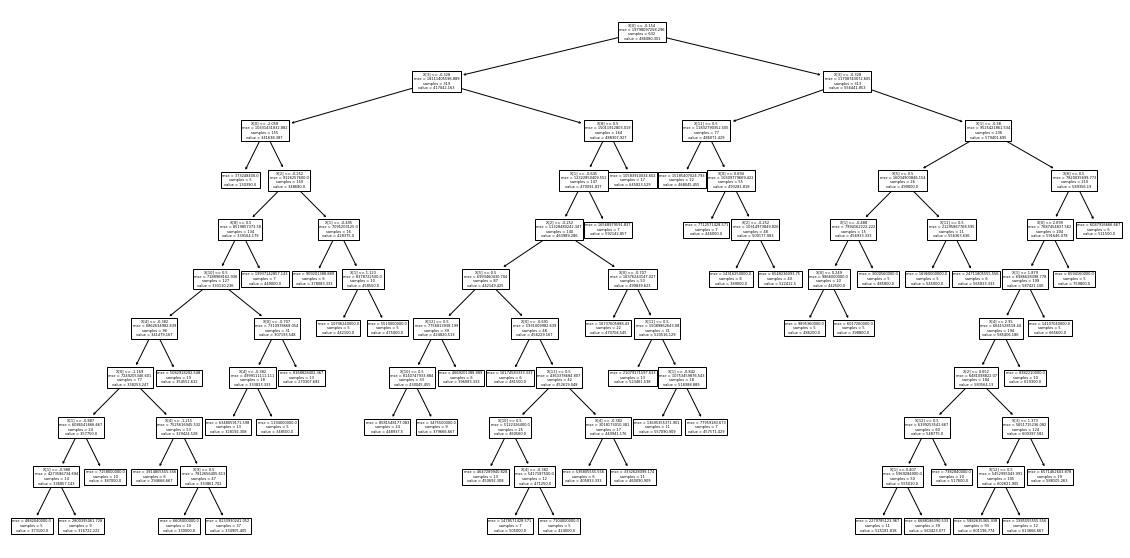

In [19]:
# view the decision tree
plt.figure(figsize = (20, 10))
plot_tree(dt_test.best_estimator_["model"])
plt.show()

## Gradient Boosting Regressor

In [20]:
# set up gradient boosting model
regress_gb = GradientBoostingRegressor(random_state = 123, ccp_alpha = 0.01)

In [21]:
# decision tree pipeline
gb = pipeMaker(regress_gb)

# determine best parameters
param_grid = {
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [5, 10, 20],
    'model__min_samples_leaf':[1, 5, 10, 15],
    'model__max_features':["auto", "sqrt", "log2"],
}

# use gridsearchCV to determine which model params lead to the best model
# based on RMSE
gb_test = GridSearchCV(gb, param_grid, cv=10, scoring = "neg_mean_squared_error")
gb_test.fit(X_train, y_train)
gb_test.best_params_

{'model__max_depth': 3,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 20}

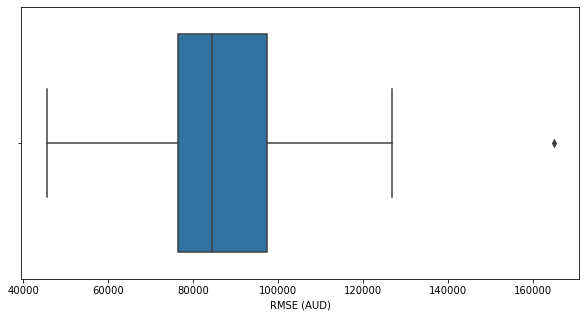

In [22]:
scores = cross_val_score(gb_test.best_estimator_, X_test, y_test, scoring = "neg_mean_squared_error", cv = 25)
RMSEs = (-1 * scores)**0.5

plt.figure(figsize = (10, 5))
sb.boxplot(x = RMSEs)
plt.xlabel("RMSE (AUD)")
plt.show()

In [23]:
# best gradient boosting model according to gridsearchCV in both RMSE and MAE
# improved performance over decision tree, and no overfitting
getModelPerf("Gradient Boosting Model", gb_test, X_train, y_train, X_test, y_test)

Gradient Boosting Model Performance

Training
RMSE: 80903.03003981354
MAE: 62168.32768203028

Test
RMSE: 87969.36918240116
MAE: 68884.80788929528


In [24]:
# make the following adjustments to reduce overfitting:
# - add subsample = 0.5 (regularization to reduce variance)
regress_gb2 = GradientBoostingRegressor(random_state = 123, ccp_alpha = 0.01, 
                                     max_depth = 3, min_samples_leaf = 1, 
                                    min_samples_split = 20, max_features = "sqrt",
                                       subsample = 0.5)
gb2 = pipeMaker(regress_gb2)

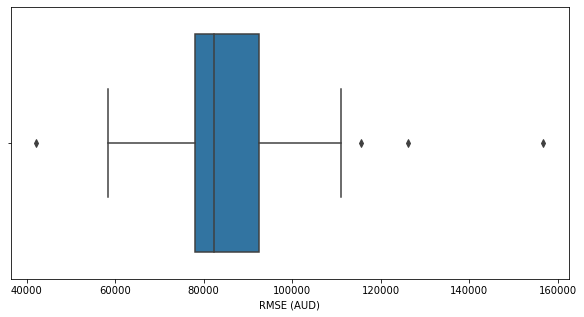

In [25]:
scores = cross_val_score(gb2, X_test, y_test, scoring = "neg_mean_squared_error", cv = 25)
RMSEs = (-1 * scores)**0.5

plt.figure(figsize = (10, 5))
sb.boxplot(x = RMSEs)
plt.xlabel("RMSE (AUD)")
plt.show()

In [26]:
# improved performance - model generalizes better on the testing data
# testing performance improved over the original best model
gb2.fit(X_train, y_train)
getModelPerf("Gradient Boosting Model (Subsampled)", gb2, X_train, y_train, X_test, y_test)

Gradient Boosting Model (Subsampled) Performance

Training
RMSE: 81767.37901169198
MAE: 63618.012762477236

Test
RMSE: 85967.02244773197
MAE: 65196.84907461885
